Xcm: 6.76 +/- 0.05
Ycm: 7.73 +/- 0.05


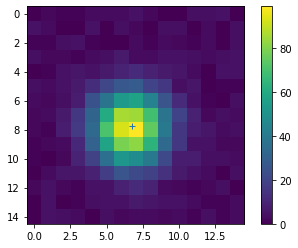

In [10]:
from math import *
import numpy as np
import pandas as pd

k = 0.01720209895
cAU = 173.144643267
eps = radians(23.4374)
G = 6.674 * (10 ** -11)
Ep = radians(23.4374)

def HMStoDegOrRad(h, m, s, option):
    deg = (h * 15) + (m * (1/60) * 15) + (s * (1/3600) * 15)
    if (option):
        return deg
    else:
        return deg * (np.pi/180)
        
def DMStoDeg(d, am, asec):
    return ((float(d)) + (copysign(float(am), float(d)) * (1/60)) + (copysign(float(asec), float(d)) * (1/3600)))

def FindAngle(s, c):
    return (atan2(s, c) + 2*np.pi) % (2*np.pi)

def RAdecimalToHMS(val):
    h = trunc(val / 15)
    val = (abs(val) / 15) - abs(h)
    m = trunc(val / (1/60))
    val = val - (m * (1/60))
    s = val / (1/3600)
    s = round(s, 0)
    if (s == 60):
        s = 0
        m += 1
    print ("RA:", h, ":", m, ":", s)

def DECdecimalToDMS(dec):
    d = trunc(dec)
    dec = abs(dec) - abs(d)
    m = trunc(dec / (1/60))
    dec -= (m * (1/60))
    s = dec / (1/3600)
    s = round(s, 0)
    if (s == 60):
        s = 0
        m += 1
    print ("Dec:", d, ":", m, ":", s)
    
def GetMagnitude(v):
    return sqrt(v[0]**2 + v[1]**2 + v[2]**2)

def AltAzToRADec(alt, az, lst):
    lst = HMStoDegOrRad(lst[0], lst[1], lst[2], False)
    lat = 40 * np.pi/180
    az = az * np.pi/180
    alt = alt * np.pi/180
    
    dec = np.arcsin(np.sin(lat) * np.sin(alt) + np.cos(lat) * np.cos(alt) * np.cos(az))

    HA = FindAngle((np.sin(2*np.pi - az) * np.cos(alt) / np.cos(dec)), (np.sin(alt) - np.sin(lat) * np.sin(dec)) / (np.cos(lat) * np.cos(dec)))
    RA = lst - HA
    
    RA = RA * 180/np.pi / 15
    if RA < 0:
        RA += 24
    
    dec = dec * 180/np.pi
    
    return RA, dec
    
def DotVectors(v1, v2):
    return v1[0]*v2[0]+v1[1]*v2[1]+v1[2]*v2[2]
    
def CrossVectors(v1, v2):
    return [v1[1]*v2[2] - v1[2]*v2[1], -(v1[0]*v2[2] - v2[0]*v1[2]), v1[0]*v2[1] - v2[0]*v1[1]]
    
def TripleProduct(v1, v2, v3):
    return DotVectors(CrossVectors(v2, v3), v1)

def NewtonMethod(func, deriv, iguess, error):
    x = iguess
    while 1:
        temp = x
        x = x - (func(x) / deriv(x))
        if abs(temp - x) < error:
            return x

def InputCSV(path):
    data = np.loadtxt(path, dtype=float, delimiter=',')
    return np.array(data)

# Runs fine
def CalculateAngularMomentum(v1, v2):
    return [round((v1[1]*v2[2] - v1[2]*v2[1]), 6), round(-(v1[0]*v2[2] - v2[0]*v1[2]), 6), round((v1[0]*v2[1] - v2[0]*v1[1]), 6)]
    
#CalculateAngularMomentum('/home/vumat/Desktop/Python_Code/VuInput.csv')

path = '/home/vumat/Desktop/Python_Code/VuInput.csv'

def PrintOrbitalElements(value, expected, error):
    print('Calculated Value:', value)
    print('Expected Value:', expected)
    print('Error(%):', error)

def CalculateOrbitalElements(path):
    ad = InputCSV(path)
    conversionRate = 58.13244
    orbitInfo = ad[0]
    
    r = np.array(orbitInfo[0:3]) 
    v = np.array(orbitInfo[3:6]) * conversionRate
    h = CalculateAngularMomentum(r, v)
    t = orbitInfo[6]
    expected = orbitInfo[7:len(orbitInfo)]
    
    # Calculate orbital elements
    a = 1 / ((2/GetMagnitude(r)) - (GetMagnitude(v) ** 2))
    e = np.sqrt(1 - ((GetMagnitude(h)) ** 2 / a))
    i = np.arccos(h[2] / GetMagnitude(h))
    omega = FindAngle((h[0] / (GetMagnitude(h) * np.sin(i))), (-h[1] / (GetMagnitude(h) * np.sin(i))))
    
    U = FindAngle((r[2] / (GetMagnitude(r) * np.sin(i))), (r[0] * np.cos(omega) + r[1] * np.sin(omega)) / GetMagnitude(r))
    nu = FindAngle((a * (1 - e ** 2) / (GetMagnitude(h) * e) * DotVectors(r, v) / GetMagnitude(r)), (1 / e) * ((a * (1 - e ** 2)) / GetMagnitude(r) - 1))
    w = U - nu
    if w < 0:
        w += 2 * np.pi
    
    E = FindAngle(GetMagnitude(r) * np.sin(nu) / (a * np.sqrt(1 - e ** 2)), (e + np.cos(nu)) / (1 + e * np.cos(nu)))
    M = E - e * np.sin(E)
    T = t - M / (k / a ** 1.5)
    
    i = degrees(i)
    omega = degrees(omega)
    w = degrees(w)
    E = degrees(E)
    M = degrees(M)
    
    # Calculate percent errors
    da = abs((a - expected[9]) / expected[9]) * 100
    de = abs((e - expected[0]) / expected[0]) * 100
    di = abs((i - expected[2]) / expected[2]) * 100
    domega = abs((omega - expected[3]) / expected[3]) * 100
    dw = abs((w - expected[4]) / expected[4]) * 100
    dM = abs((M - expected[7]) / expected[7]) * 100
    dT = abs((T - expected[5]) / expected[5]) * 100
    
    #print('Semi-major axis(AU):\n')
    #PrintOrbitalElements(a, expected[9], da)
    #print('\nEccentricity:\n')
    #PrintOrbitalElements(e, expected[0], de)
    #print('\nInclination(degrees):\n')
    #PrintOrbitalElements(i, expected[2], di)
    #print('\nOmega(degrees):\n')
    #PrintOrbitalElements(omega, expected[3], domega)
    #print('\nAngle of perihelion(degrees):\n')
    #PrintOrbitalElements(w, expected[4], dw)
    #print('\nMean anomaly(degrees):\n')
    #PrintOrbitalElements(M, expected[7], dM)
    #print('\nTime of perihelion passage(days):\n')
    #PrintOrbitalElements(T, expected[5], dT)
    
    return a, e, i, omega, w, M, T, da, de, di, domega, dw, dM, dT

taus = [-0.15481889055, 0.15481889055, 0.3096377811]  
Sun2 = [-0.2398478458274071, 0.9065739917845802, 0.3929623749770952]  
rhohat2 = [-0.8518563498182248, -0.2484702599212149, 0.4610892421311239]  
Ds = [-0.0010461861084885213, -0.17297581974209159, -0.17201260125558127, -0.16712421570714076]
Rroots = [1.014886625023963, 1.2932503440012362, 1.5851855408957922]  
Rrhos = [0.012425430826237482, 0.9753289007273918, 1.386900042701193]

def SEL(taus, Sun2, rhohat2, Ds):
    roots = [0., 0., 0.] 
    rhos = [0., 0., 0.]
    
    E = -2 * (DotVectors(rhohat2, Sun2))
    F = GetMagnitude(Sun2) ** 2
    A1 = taus[1] / taus[2]
    B1 = A1 / 6 * (taus[2] ** 2 - taus[1] ** 2)
    A3 = -taus[0] / taus[2]
    B3 = A3 / 6 * (taus[2] ** 2 - taus[0] ** 2)
    
    A = (A1 * Ds[1] - Ds[2] + A3 * Ds[3]) / (-Ds[0])
    B = (B1 * Ds[1] + B3 * Ds[3]) / (-Ds[0])
    
    a = -(A ** 2 + A * E + F)
    b = -(2 * A * B + B * E)
    c = -(B ** 2)
    
    poly = [1, 0, a, 0, 0, b, 0, 0, c]
    roots = [np.real(x) for x in np.roots(poly) if (np.isreal(x) and x > 0)]
    roots.sort()
    
    rhos = [A + B / x ** 3 for x in roots]
    rhos.sort()
    
    errorsRoots = np.array([])
    for i in range(0, len(roots)):
        errorsRoots = np.append(errorsRoots, abs((roots[i] - Rroots[i]) / Rroots[i]) * 100)
        
    errorsRhos = np.array([])
    for i in range(0, len(rhos)):
        errorsRhos = np.append(errorsRhos, abs((rhos[i] - Rrhos[i]) / Rrhos[i]) * 100)
    
    return roots, rhos, errorsRoots, errorsRhos

def GenerateEphemeris(path):
    ad = InputCSV(path)
    a, e, i, omega, w, M, T, da, de, di, domega, dw, dM, dT = CalculateOrbitalElements(path)
    realRADec = ad[1][0:6]
    rSun = ad[1][6:9]
    
    rRA = HMStoDegOrRad(realRADec[0], realRADec[1], realRADec[2], False)
    rDec = radians(DMStoDeg(realRADec[3], realRADec[4], realRADec[5]))
    inp = input('Enter input as: [year] [month] [day] [hour] [minute] [second] -- ')
    inp = inp.split()
    inp = [int(x) for x in inp]
    
    ts = pd.Timestamp(year = inp[0],  month = inp[1], day = inp[2], hour = inp[3], second = inp[4], tz = 'UTC')
    ts = ts.to_julian_date()
    M = (k * np.sqrt(1 / a ** 3) * (ts - T))
    
    E = NewtonMethod(lambda x: M - (x - e * np.sin(x)), lambda x: e * np.cos(x) - 1, M, 1e-10)
    while abs((E - e * np.sin(E)) - M) > 1e-10:
        E = NewtonMethod(lambda x: M - (x - e * np.sin(x)), lambda x: e * np.cos(x) - 1, M, 1e-10)
    x = a * np.cos(E) - a * e
    y = a * np.sqrt(1 - e ** 2) * np.sin(E)
    z = 0
    v = np.array([x, y, z])

    omega = radians(omega)
    i = radians(i)
    w = radians(w)

    rotMat1 = np.array([[np.cos(omega), -np.sin(omega), 0], [np.sin(omega), np.cos(omega), 0], [0, 0, 1]])   
    rotMat2 = np.array([[1, 0, 0], [0, np.cos(i), -np.sin(i)], [0, np.sin(i), np.cos(i)]])
    rotMat3 = np.array([[np.cos(w), -np.sin(w), 0], [np.sin(w), np.cos(w), 0], [0, 0, 1]])
    rotMat4 = np.array([[1, 0, 0], [0, np.cos(Ep), -np.sin(Ep)], [0, np.sin(Ep), np.cos(Ep)]])
    
    rot1 = np.matmul(rotMat3, v)
    rot2 = np.matmul(rotMat2, rot1)
    v1 = np.matmul(rotMat1, rot2)
    v2 = np.matmul(rotMat4, v1)
    rho = v2 - np.array(rSun)
    rhoHat = rho / GetMagnitude(rho)
    dec = degrees(np.arcsin(rhoHat[2]))
    RA = degrees(FindAngle(rhoHat[1] / np.cos(dec), rhoHat[0] / np.cos(dec)))
    errRA = abs((degrees(rRA) - RA) / degrees(rRA)) * 100
    errDec = abs((degrees(rDec) - dec) / degrees(rDec)) * 100
    
    return RA, dec, errRA, errDec
    
#roots, rhos, errorsRoots, errorsRhos = SEL(taus,Sun2,rhohat2,Ds) 

#CalculateOrbitalElements(path)

def CalculateDs(path):
    ad = InputCSV(path)

    RAs = np.array([HMStoDegOrRad(ad[i][0], ad[i][1], ad[i][2], False) for i in range(2, 5)])
    Decs = np.array([radians(DMStoDeg(ad[i][3], ad[i][4], ad[i][5])) for i in range(2, 5)])
    
    Rsuns = np.array([ad[i][6:9] for i in range(2, 5)])
    rhoHats = np.array([np.array([np.cos(Decs[i]) * np.cos(RAs[i]), np.sin(RAs[i]) * np.cos(Decs[i]), np.sin(Decs[i])]) for i in range(3)])
    D0 = DotVectors(rhoHats[0], CrossVectors(rhoHats[1], rhoHats[2]))
    D1s = np.array([DotVectors(CrossVectors(Rsuns[i], rhoHats[1]), rhoHats[2]) for i in range(3)])
    D2s = np.array([DotVectors(CrossVectors(rhoHats[0], Rsuns[i]), rhoHats[2]) for i in range(3)])
    D3s = np.array([DotVectors(rhoHats[0], CrossVectors(rhoHats[1], Rsuns[i])) for i in range(3)])
    
    return D0, D1s, D2s, D3s
    
#RA, dec, errRA, errDec = GenerateEphemeris(path)
#RAdecimalToHMS(RA)
#DECdecimalToDMS(dec)
#print('Error in RA(%):', errRA)
#print('Error in Dec(%):', errDec)

#CalculateDs(path)

def CalculateCentroid(path):
    ad = InputCSV(path)

    sumNX = sumNY = sumN = sumDelX = sumDelY = 0
    for i in range(len(ad)):
        for j in range(len(ad[0])):
            sumNX += ad[i][j] * j
            sumNY += ad[i][j] * i
            sumN += ad[i][j]
            
    xcm = sumNX / sumN
    ycm = sumNY / sumN
    
    for i in range(len(ad)):
        for j in range(len(ad[0])):
            sumDelX += (j - xcm) ** 2 * ad[i][j]
            sumDelY += (i - ycm) ** 2 * ad[i][j]
    
    delxcm = 1 / sumN * np.sqrt(sumDelX)
    delycm = 1 / sumN * np.sqrt(sumDelY)
    
    print('Xcm:', round(xcm, 2), '+/-', round(delxcm, 2))
    print('Ycm:', round(ycm, 2), '+/-', round(delycm, 2))
    
    map = plt.imshow(ad)
    plt.colorbar(map)
    plt.plot(xcm, ycm, '+')
    plt.show()
    
CalculateCentroid('/home/vumat/Desktop/Python_Code/centroidData.csv')